In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir(r'/content/drive/My Drive/DeepfakeDetector')

In [0]:
from google.colab import files
token = files.upload()

In [0]:
!mkdir /root/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [0]:
!cp kaggle.json /root/.kaggle/

In [0]:
# downlaod the kaggle dataset using kaggle api and unzip images into data folder
# !kaggle datasets download -d dagnelies/deepfake-faces

In [0]:
# !unzip -o 'deepfake-faces.zip' -d data/

In [0]:
# Install OpenCV
# !pip install opencv-contrib-python
# !pip install numpy

import keras
from keras import optimizers, regularizers
from keras.datasets import mnist
from keras.applications import VGG16, VGG19, InceptionResNetV2, Xception, NASNetLarge
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing import image
from keras.models import Model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import cv2

import pickle
from keras.models import model_from_json
from keras.models import load_model
import matplotlib.pyplot as plt
from IPython.display import display, Image

import numpy as np
import csv
import glob
import random
import math

# !wget https://raw.githubusercontent.com/archarbar/DeepfakeDetector/master/metadata.csv

['lqdtpjdrrw.mp4', '108', '107', 'FAKE', 'vcoxcsxkmq.mp4']
['mjoafcwkac.mp4', '267', '268', 'FAKE', 'evirwnkqms.mp4']
['mvneuvwisv.mp4', '223', '223', 'REAL', '']
['laugsqcihw.mp4', '129', '129', 'REAL', '']
['qxkhenevls.mp4', '43', '43', 'FAKE', 'ejzrvimtcm.mp4']
['fryjurazkm.mp4', '223', '222', 'FAKE', 'imtkdzkypf.mp4']
['cykdqoymho.mp4', '129', '129', 'REAL', '']
['dqqeyuatkw.mp4', '129', '129', 'FAKE', 'ofmrqfemne.mp4']
['ecxpywhqcl.mp4', '108', '107', 'FAKE', 'gtgqxspgjl.mp4']
['vlzwcejywm.mp4', '321', '321', 'REAL', '']
84.38
15.62
5000
5000


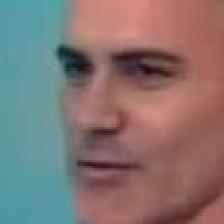

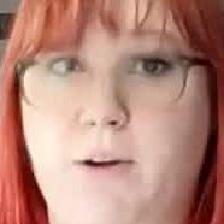

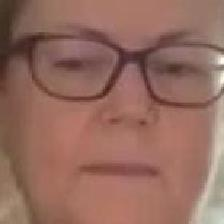

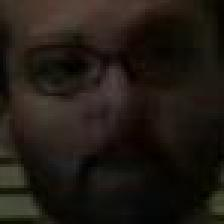

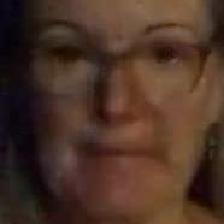

(1,) (5000,)
[array([[136, 136, 136, ..., 109, 109, 109],
       [136, 136, 136, ..., 109, 109, 109],
       [136, 136, 136, ..., 111, 111, 111],
       ...,
       [129, 129, 129, ..., 120, 120, 120],
       [129, 129, 129, ..., 120, 120, 120],
       [129, 129, 129, ..., 120, 120, 120]], dtype=uint8)
 'data/faces_224/pcrosucgdh.jpg' 'data/faces_224/wbeplfzuvf.jpg' ...
 'data/faces_224/rsapxoqybk.jpg' 'data/faces_224/pkxgbfppae.jpg'
 'data/faces_224/pjmstnfxfv.jpg']


In [0]:
# read metadata file to create label list
dataset_filename = 'metadata.csv'
with open(dataset_filename) as csv_file:
  csv_reader = csv.reader(csv_file)
  colnames = next(csv_reader)
  data = list(csv_reader)

for label in random.sample(data, 10):
  print(label)

random.shuffle(data)

X = [] #features
y = [] #labels

fake = 0
real = 0

#create features and labels lists.
# append image path (change .mp4 extension to jpg) and append classes
for element in data[:5000]:
  element[0] = 'data/faces_224/' + element[0][:-3] + 'jpg'
  if (element[3] == 'FAKE'):
    X.append(element[0])
    y.append(0)
    fake += 1
  else:
    X.append(element[0])
    y.append(1)
    real +=1

#calculating class balance
print(100*fake/len(y))
print(100*real/len(y))

print(len(X))
print(len(y))

# The size of the images
IMG_SIZE = 224

sample_images = X[:5]
for file_path in sample_images:
  display(Image(file_path))

# X = np.stack([cv2.imread(str(x), cv2.IMREAD_GRAYSCALE) 
#                    for x in img_paths])

# use open cv to read and resize images into arrays
for c, v in enumerate(X):
  img_array = cv2.imread(v, cv2.IMREAD_GRAYSCALE)
  if (img_array is None):
    print("error image not found: ", v)
    continue
  X[c] = img_array

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)

# Creating pickle files to save features and classes
pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

# **CNN**

(3500, 224, 224, 1) (3500,)
(1500, 224, 224, 1) (1500,)
Train on 3500 samples, validate on 1500 samples
Epoch 1/10
3500/3500 [==============================] - 290s 83ms/step - loss: 1.2075 - acc: 0.8371 - val_loss: 0.6916 - val_acc: 0.8240
Epoch 2/10
3500/3500 [==============================] - 288s 82ms/step - loss: 0.5555 - acc: 0.8409 - val_loss: 0.5416 - val_acc: 0.8240
Epoch 3/10
3500/3500 [==============================] - 291s 83ms/step - loss: 0.4828 - acc: 0.8409 - val_loss: 0.5263 - val_acc: 0.8240
Epoch 4/10
3500/3500 [==============================] - 290s 83ms/step - loss: 0.4628 - acc: 0.8409 - val_loss: 0.4826 - val_acc: 0.8240
Epoch 5/10
3500/3500 [==============================] - 288s 82ms/step - loss: 0.4551 - acc: 0.8409 - val_loss: 0.4844 - val_acc: 0.8240
Epoch 6/10
3500/3500 [==============================] - 287s 82ms/step - loss: 0.4520 - acc: 0.8409 - val_loss: 0.4826 - val_acc: 0.8240
Epoch 7/10
3500/3500 [==============================] - 290s 83ms/step - l

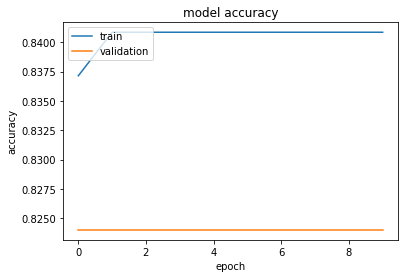

In [0]:
X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

# normalizing data (pixel is from 0 to 255)
X = X/255.0
X = X.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

# Building the model
model = Sequential()
# 3 convolutional layers
model.add(Conv2D(32, (3, 3), input_shape = (X.shape[1:])))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2 hidden layers
model.add(Flatten())
model.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation("relu"))

model.add(Dense(128, kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation("relu"))

# The output layer
model.add(Dense(2))
model.add(Activation("sigmoid"))

# Compiling the model using some basic parameters
# sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy",
				optimizer="adam",
				metrics=["accuracy"])

#splitting into train and test sets, with a 70% split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)

# Training the model, with 20 iterations
history = model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, y_test))

# Saving the model
model_json = model.to_json()
with open("model.json", "w") as json_file :
	json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

model.save('CNN.model')

# Printing a graph showing the accuracy changes during the training phase
print(history.history.keys())
plt.figure(1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

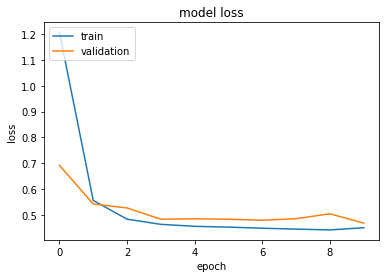

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [0]:
X = pickle.load(open("X.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

# normalizing data (pixel is from 0 to 255)
X = X/255.0

#splitting into train and test sets, with a 70% split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = X_train.reshape(len(X_train),-1)
X_test = X_test.reshape(len(X_test),-1)

print(X_train.shape)
print(X_test.shape)

rfc = RandomForestClassifier()

classificer = rfc.fit(X_train, y_train)
print('Training accuracy: ', rfc.score(X_train, y_train))
print('Testing accuracy: ', rfc.score(X_test, y_test))

(3500, 50176)
(1500, 50176)
Training accuracy:  1.0
Testing accuracy:  0.83


[[0.99518459 0.00481541]
 [0.98031496 0.01968504]]


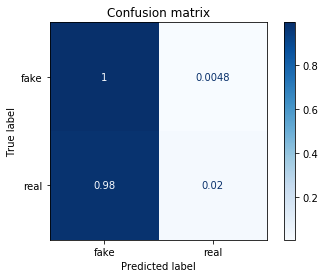

In [0]:
disp = plot_confusion_matrix(classificer, X_test, y_test,
                                 display_labels=["fake", "real"],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title("Confusion matrix")

print(disp.confusion_matrix)